<a href="https://colab.research.google.com/github/Usman-938/CCTV-Smart-Change-Detector/blob/main/CCTV_Change_Detection_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CCTV Change Detection System
Detects changes, captures before/after frames, logs timestamps.

**Steps:** Run Cell 1 once (install), then Cell 2-4 (setup), then Cell 5 (demo) or Cell 6 (your video).

In [1]:
# CELL 1: Install
!pip install opencv-python-headless numpy matplotlib Pillow tqdm -q
print('Done!')

Done!


In [2]:
# CELL 2: Imports
import cv2, numpy as np, os, json
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm
import warnings; warnings.filterwarnings('ignore')
print('Imports OK')

Imports OK


In [3]:
# CELL 3: Config
class Config:
    CHANGE_THRESHOLD         = 30
    MIN_CHANGED_AREA_PERCENT = 2.0
    MOTION_BLUR_KERNEL       = 5
    FRAME_SKIP               = 2
    BUFFER_SECONDS           = 2.0
    MIN_EVENT_GAP_SECONDS    = 3.0
    OUTPUT_DIR               = 'cctv_output'
    DISPLAY_LIVE             = False
    DISPLAY_EVERY_N          = 30
print('Config OK')

Config OK


In [4]:
# CELL 4: Core Engine
class FrameBuffer:
    def __init__(self, max_sec, fps):
        self.max_frames = max(1, int(max_sec * fps))
        self.buf = []
    def add(self, frame, ts):
        self.buf.append((frame.copy(), ts))
        if len(self.buf) > self.max_frames: self.buf.pop(0)
    def earliest(self): return self.buf[0] if self.buf else (None, None)
    def latest(self):   return self.buf[-1] if self.buf else (None, None)

class ChangeDetector:
    def __init__(self, cfg):
        self.cfg = cfg
        self.bgs = cv2.createBackgroundSubtractorMOG2(history=200, varThreshold=50, detectShadows=True)
        self.prev = None
        self.area = None
    def score(self, frame):
        h, w = frame.shape[:2]
        if self.area is None: self.area = h * w
        gray = cv2.GaussianBlur(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY),
                                (self.cfg.MOTION_BLUR_KERNEL,)*2, 0)
        fg = np.where(self.bgs.apply(frame) == 255, 255, 0).astype(np.uint8)
        dm = np.zeros_like(gray)
        if self.prev is not None:
            d = cv2.absdiff(gray, self.prev)
            _, dm = cv2.threshold(d, self.cfg.CHANGE_THRESHOLD, 255, cv2.THRESH_BINARY)
        self.prev = gray
        cm = cv2.bitwise_or(fg, dm)
        k = np.ones((5,5), np.uint8)
        cm = cv2.morphologyEx(cm, cv2.MORPH_OPEN, k)
        cm = cv2.morphologyEx(cm, cv2.MORPH_CLOSE, k)
        return (np.sum(cm > 0) / self.area) * 100.0, cm

class CCTVSystem:
    def __init__(self, cfg=None):
        self.cfg = cfg or Config()
        self.det = ChangeDetector(self.cfg)
        self.events = []
        self.last_t = -999.0
        os.makedirs(self.cfg.OUTPUT_DIR, exist_ok=True)

    def analyze(self, path, start_str=None):
        cap = cv2.VideoCapture(str(path))
        if not cap.isOpened(): raise RuntimeError(f'Cannot open: {path}')
        fps = cap.get(cv2.CAP_PROP_FPS) or 25.0
        total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        start_dt = None
        if start_str:
            try: start_dt = datetime.strptime(start_str, '%Y-%m-%d %H:%M:%S')
            except: pass
        print(f'Video: {os.path.basename(str(path))} | {fps:.1f}fps | {total} frames')
        # Warmup
        for _ in range(min(30, total)):
            r, f = cap.read()
            if not r: break
            self.det.bgs.apply(f)
        cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
        self.det.prev = None; self.det.area = None
        buf = FrameBuffer(self.cfg.BUFFER_SECONDS, fps)
        self.events = []; self.last_t = -999.0
        fi = 0; proc = 0; scores = []; pending = None; dm = None
        pbar = tqdm(total=total, desc='Analyzing', unit='fr')
        while True:
            ret, frame = cap.read()
            if not ret: break
            fi += 1; pbar.update(1)
            if fi % self.cfg.FRAME_SKIP != 0: continue
            proc += 1
            ts = fi / fps
            wt = self._wt(ts, start_dt)
            buf.add(frame, (ts, wt))
            sc, dm = self.det.score(frame)
            scores.append((ts, sc))
            if pending is not None and (ts - pending['ts']) >= self.cfg.BUFFER_SECONDS:
                pending['after'] = frame.copy(); pending['dm'] = dm.copy()
                self._save(pending); self.events.append(pending)
                print(f'  Event #{len(self.events)} @ {pending["wt"]}')
                pending = None
            if sc >= self.cfg.MIN_CHANGED_AREA_PERCENT and (ts-self.last_t) >= self.cfg.MIN_EVENT_GAP_SECONDS and pending is None:
                self.last_t = ts
                bf = buf.earliest()[0]
                pending = {'id': len(self.events)+1, 'ts': ts, 'wt': wt, 'sc': round(sc,2),
                           'before': bf if bf is not None else frame.copy(), 'after': None, 'dm': None}
                print(f'  CHANGE @ {wt} score={sc:.1f}%')
        if pending is not None:
            lf = buf.latest()[0]
            pending['after'] = lf if lf is not None else pending['before']
            pending['dm'] = dm
            self._save(pending); self.events.append(pending)
        pbar.close(); cap.release()
        print(f'Done! Events: {len(self.events)}')
        self._timeline(scores, os.path.basename(str(path)))
        self._show()
        return self.events

    def _save(self, ev):
        p = os.path.join(self.cfg.OUTPUT_DIR, f"ev{ev['id']:03d}_t{int(ev['ts'])}s")
        cv2.imwrite(f'{p}_before.jpg', ev['before'])
        cv2.imwrite(f'{p}_after.jpg', ev['after'])
        if ev['dm'] is not None:
            cv2.imwrite(f'{p}_diff.jpg', cv2.applyColorMap(ev['dm'], cv2.COLORMAP_HOT))
        with open(f'{p}_meta.json','w') as f:
            json.dump({'event_id':ev['id'],'timestamp_sec':round(ev['ts'],3),
                       'wall_time':ev['wt'],'change_score':ev['sc']}, f, indent=2)

    def _timeline(self, scores, name):
        if not scores: return
        ts, vs = zip(*scores)
        plt.figure(figsize=(14,4))
        plt.plot(ts, vs, color='steelblue', lw=0.8, alpha=0.7, label='Score %')
        plt.axhline(self.cfg.MIN_CHANGED_AREA_PERCENT, color='orange', ls='--', label='Threshold')
        for i, ev in enumerate(self.events):
            plt.axvline(ev['ts'], color='red', lw=1.5, alpha=0.8, label='Event' if i==0 else '')
            plt.text(ev['ts'], max(vs)*0.85, f"E{i+1}", color='red', fontsize=8, ha='center', fontweight='bold')
        plt.xlabel('Time (s)'); plt.ylabel('Changed %'); plt.title(f'Timeline - {name}')
        plt.legend(); plt.tight_layout()
        plt.savefig(os.path.join(self.cfg.OUTPUT_DIR,'timeline.png'), dpi=120)
        plt.show()

    def _show(self):
        for ev in self.events:
            fig, ax = plt.subplots(1,3,figsize=(15,4))
            fig.suptitle(f"Event #{ev['id']} | {ev['wt']} | {ev['sc']}%", fontsize=12, fontweight='bold')
            ax[0].imshow(cv2.cvtColor(ev['before'], cv2.COLOR_BGR2RGB)); ax[0].set_title('BEFORE'); ax[0].axis('off')
            ax[1].imshow(cv2.cvtColor(ev['after'],  cv2.COLOR_BGR2RGB)); ax[1].set_title('AFTER');  ax[1].axis('off')
            if ev['dm'] is not None:
                ax[2].imshow(cv2.cvtColor(cv2.applyColorMap(ev['dm'],cv2.COLORMAP_HOT),cv2.COLOR_BGR2RGB))
            ax[2].set_title('DIFF'); ax[2].axis('off')
            plt.tight_layout(); plt.show()

    def export_json(self):
        out = [{'event_id':e['id'],'timestamp_sec':e['ts'],'wall_time':e['wt'],'change_score':e['sc']} for e in self.events]
        p = os.path.join(self.cfg.OUTPUT_DIR,'all_events.json')
        with open(p,'w') as f: json.dump(out,f,indent=2)
        print(f'Exported: {p}')

    @staticmethod
    def _wt(ts, sdt):
        if sdt: return (sdt+timedelta(seconds=ts)).strftime('%Y-%m-%d %H:%M:%S')
        return f'{int(ts//3600):02d}:{int(ts%3600//60):02d}:{int(ts%60):02d}'

print('Engine loaded!')

Engine loaded!


In [ ]:
# # CELL 5: Demo with Synthetic Video
# def make_test_video(path='test_cctv.mp4', dur=30, fps=25):
#     w, h = 640, 480
#     out = cv2.VideoWriter(path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w,h))
#     bg = np.full((h,w,3), 40, dtype=np.uint8)
#     evs = [(fps*5,fps*8,'p1'),(fps*12,fps*16,'obj'),(fps*22,fps*26,'p2')]
#     rng = np.random.default_rng(42)
#     for fi in range(dur*fps):
#         fr = bg.copy()
#         fr = np.clip(fr.astype(np.int16)+rng.integers(-5,5,fr.shape,dtype=np.int16),0,255).astype(np.uint8)
#         for s,e,t in evs:
#             if s<=fi<e:
#                 p=(fi-s)/max(1,e-s)
#                 if t=='p1': x=int(p*(w-100)); cv2.rectangle(fr,(x,200),(x+60,340),(160,120,90),-1); cv2.circle(fr,(x+30,185),25,(200,160,130),-1)
#                 elif t=='obj': cv2.rectangle(fr,(300,250),(380,310),(80,120,200),-1)
#                 elif t=='p2': x=int((1-p)*(w-100)); cv2.rectangle(fr,(x,200),(x+60,340),(90,160,120),-1); cv2.circle(fr,(x+30,185),25,(130,200,160),-1)
#         cv2.putText(fr,f'CAM01|{fi//fps//60:02d}:{fi//fps%60:02d}',(10,20),cv2.FONT_HERSHEY_SIMPLEX,0.5,(200,200,200),1)
#         out.write(fr)
#     out.release(); print(f'Test video: {path}'); return path

# video = make_test_video()
# cfg = Config()
# cfg.CHANGE_THRESHOLD = 25; cfg.MIN_CHANGED_AREA_PERCENT = 1.5
# cfg.FRAME_SKIP = 1; cfg.BUFFER_SECONDS = 1.5; cfg.MIN_EVENT_GAP_SECONDS = 2.0
# sys = CCTVSystem(cfg)
# events = sys.analyze(video, start_str='2024-06-01 08:00:00')
# sys.export_json()
# print(f'Total events: {len(events)}')

Video: WhatsApp Video 2026-02-24 at 12.41.23 AM.mp4 | 29.9fps | 1250 frames


Analyzing:  23%|██▎       | 285/1250 [00:03<00:14, 67.87fr/s]

  CHANGE @ 00:00:09 score=2.0%


Analyzing:  28%|██▊       | 349/1250 [00:05<00:16, 54.16fr/s]

  Event #1 @ 00:00:09


Analyzing:  32%|███▏      | 401/1250 [00:05<00:13, 63.60fr/s]

  CHANGE @ 00:00:12 score=2.6%


Analyzing:  37%|███▋      | 457/1250 [00:06<00:13, 56.90fr/s]

  Event #2 @ 00:00:12


Analyzing:  57%|█████▋    | 707/1250 [00:11<00:07, 74.37fr/s]

  CHANGE @ 00:00:23 score=2.5%


Analyzing:  62%|██████▏   | 769/1250 [00:12<00:07, 62.36fr/s]

  Event #3 @ 00:00:23


Analyzing:  70%|██████▉   | 873/1250 [00:14<00:05, 69.41fr/s]

  CHANGE @ 00:00:28 score=3.3%


Analyzing:  74%|███████▍  | 929/1250 [00:14<00:04, 67.08fr/s]

  Event #4 @ 00:00:28


Analyzing:  77%|███████▋  | 958/1250 [00:15<00:04, 60.84fr/s]

  CHANGE @ 00:00:31 score=10.3%


Analyzing:  82%|████████▏ | 1021/1250 [00:16<00:03, 57.36fr/s]

  Event #5 @ 00:00:31


Analyzing: 100%|██████████| 1250/1250 [00:19<00:00, 63.46fr/s]


Done! Events: 5


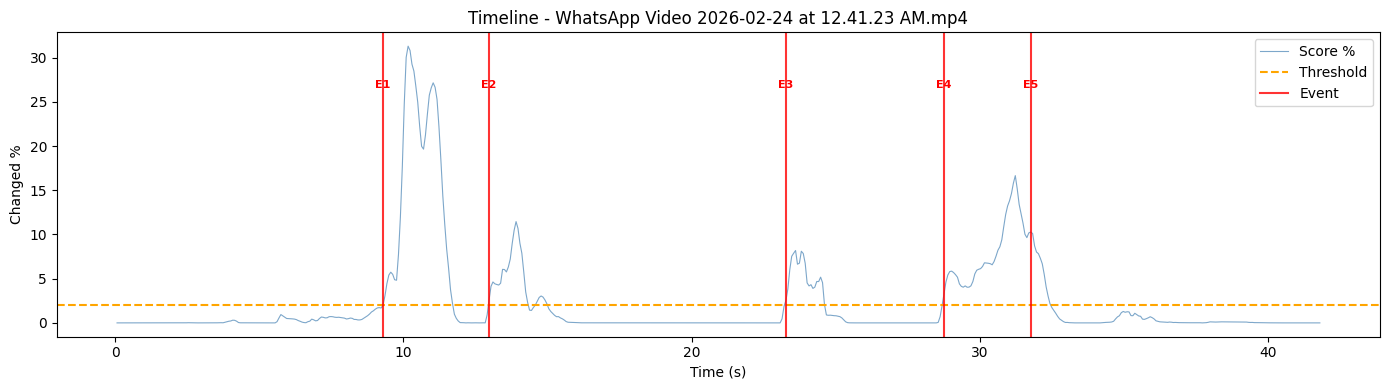

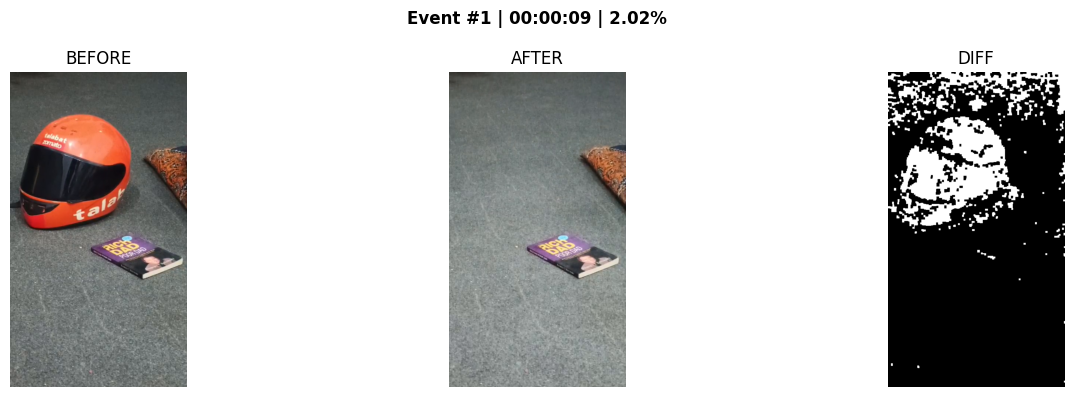

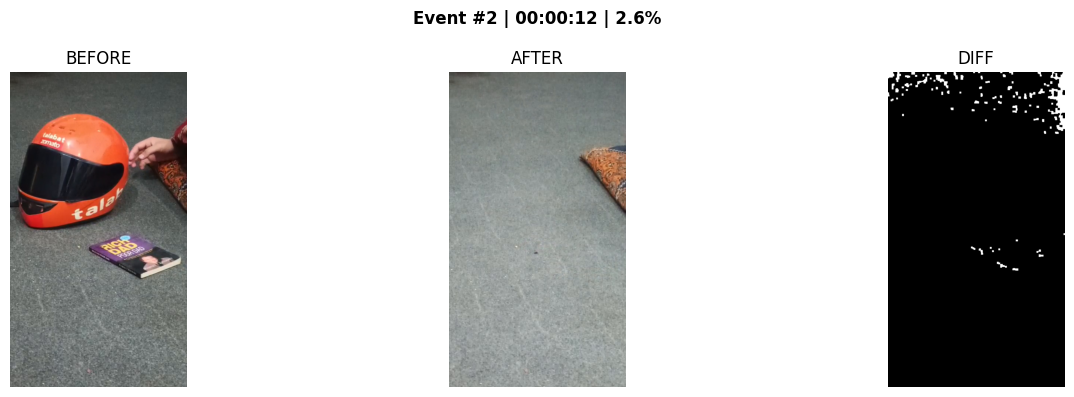

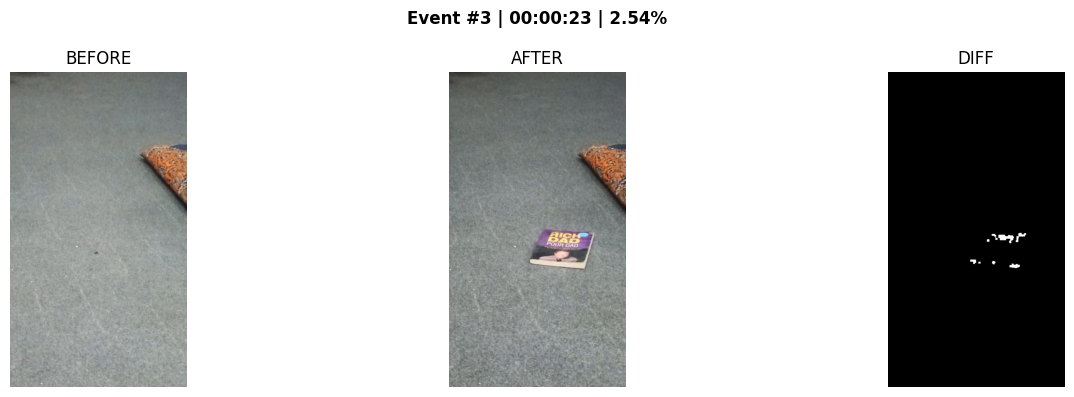

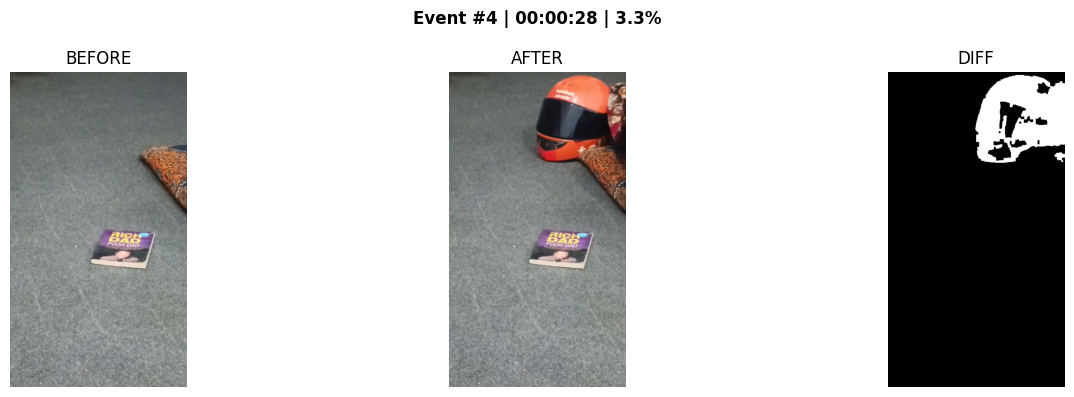

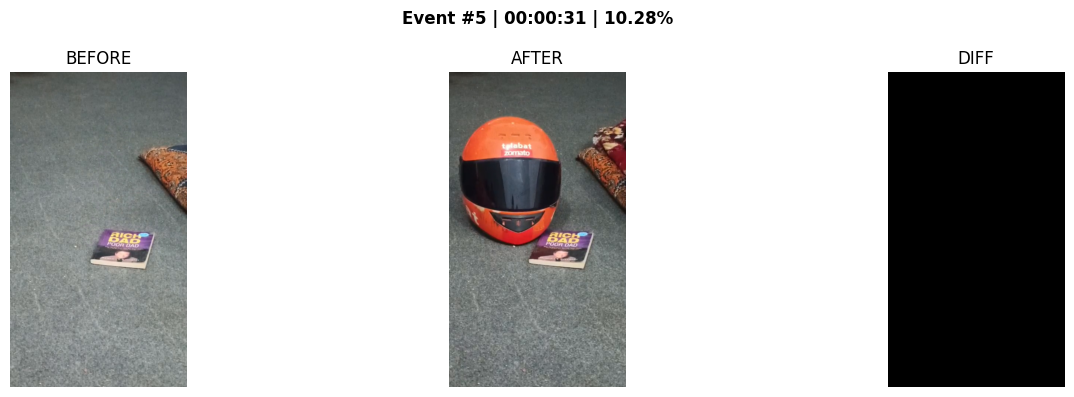

Exported: cctv_output/all_events.json


In [12]:
# CELL 6: Run on YOUR Video
# Uncomment one of these to upload/mount:
#
# from google.colab import files
# uploaded = files.upload()
# video_path = list(uploaded.keys())[0]
#
# from google.colab import drive
# drive.mount('/content/drive')
# video_path = '/content/drive/MyDrive/your_cctv.mp4'

video_path = '/content/WhatsApp Video 2026-02-24 at 12.41.23 AM.mp4'  # <- change this

cfg = Config()
cfg.CHANGE_THRESHOLD         = 40
cfg.MIN_CHANGED_AREA_PERCENT = 2.0
cfg.BUFFER_SECONDS           = 2.0
cfg.MIN_EVENT_GAP_SECONDS    = 3.0
cfg.FRAME_SKIP               = 2

sys2 = CCTVSystem(cfg)
events = sys2.analyze(video_path, start_str=None)  # add '2024-06-01 08:30:00' for real timestamps
sys2.export_json()

In [13]:
# CELL 7: Download Results
import zipfile
from google.colab import files
zip_path = 'cctv_results.zip'
with zipfile.ZipFile(zip_path, 'w') as zf:
    for root, dirs, fnames in os.walk(cfg.OUTPUT_DIR):
        for fn in fnames:
            zf.write(os.path.join(root, fn))
print(f'Zipped: {zip_path}')
files.download(zip_path)

Zipped: cctv_results.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>